In [1]:
import sys
sys.path.append('../src/')

%load_ext autoreload
%autoreload 2

# Tutorial: Impact of the parameter $\alpha$ in the solutions of the BOT problems

As outlined in the paper, Branched Optimal Transport (BOT) problems extend the scope of classical Optimal Transport problems by introducing subadditive transportation costs $m_{ij}$ along edges $(i,j)$. This subadditivity arises from the inclusion of the parameter $\alpha \in [0,1]$ in the cost function, defined as:

$$
\sum_{(i,j)\in E} m_{ij}^\alpha \ ||x_i-x_j||_2,
$$

where $x_i$ and $x_j$ denote the coordinates of nodes $i$ and $j$ respectively. The subadditivity manifests in various forms depending on the specific value of $\alpha$. In this tutorial, we delve deeper into this concept and its implications.


### Step 1: Setup and Imports
To get started, we will import the necessary modules and configure our environment. The following modules are imported in this code snippet:

In [2]:
import numpy as np
import time
import networkx as nx
import matplotlib.pyplot as plt
#-------------------------------------------
import utils
import iterative_geometry_solver as igs
import greedy_topology_optimization as gto

### Step 2: Small example -- impact of $\alpha$ on the optimal geometry
First, let us illustrate the effect of the subaddititivity of the cost function, i.e. $(m_1 + m_2)^\alpha \leq m_1^\alpha + m_2^\alpha$, at a small example with one source and two sinks. The inequality and hence the discount for transporting mass together gets stronger the smaller $\alpha$ is. Thus $\alpha$ strongly effects the optimal branching angles and thereby the optimal geometry.

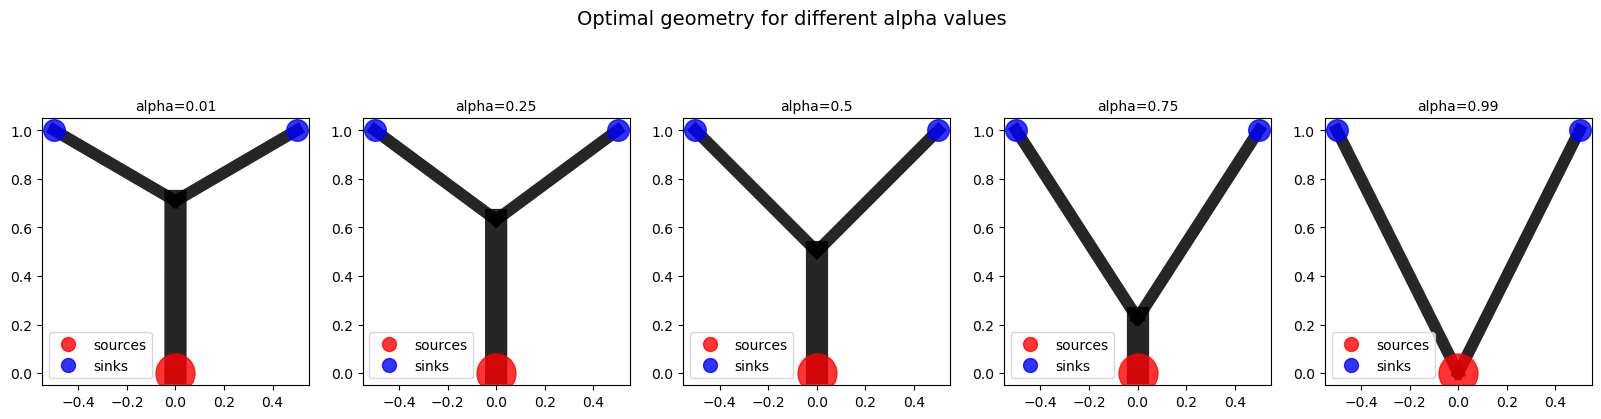

In [3]:
bot_problem_dict = {
    "al": 0.5,
    "coords_sources": np.array([[0.0, 0.0]]),
    "coords_sinks": np.array([[-0.5, 1], [0.5, 1]]),
    "supply_arr": np.array([1.0]),
    "demand_arr": np.array([0.5, 0.5])
}

alphas = [0.01, 0.25, 0.50, 0.75, 0.99]

# use trivial topology with 1 branching point:
topo = nx.Graph()
for node in range(len(bot_problem_dict["supply_arr"]) + len(bot_problem_dict["demand_arr"])):
    topo.add_edge(-1, node)

coords_sources = bot_problem_dict["coords_sources"]
coords_sinks = bot_problem_dict["coords_sinks"]
supply_arr = bot_problem_dict["supply_arr"]
demand_arr = bot_problem_dict["demand_arr"]

fig, axes = plt.subplots(1, len(alphas), figsize=(20, 5))
fig.suptitle("Optimal geometry for different alpha values", fontsize=14)

for i, al in enumerate(alphas):
    cost, coords_iter = igs.iterative_geometry_solver(topo, supply_arr, demand_arr, coords_sources, coords_sinks, al,
                                         relative_improvement_threshold=1e-7, min_iterations=-1,
                                         max_iterations=2000,
                                         plot=False, title="", fov=None, save=False, save_name=f"img{np.round(al,2)}")

    # print("BOT solution with optimal geometry for alpha = ", al)
    # add current figure to the plot:
    utils.visualise_BOT_solution(topo,
                   coords_iter,
                   supply_arr,
                   demand_arr,
                   title=f"alpha={al}", save=False, save_name="img", fs = 10, subplot_ax=axes[i])

plt.show()

### Step 3: Define Problem Parameters
Let us now look at a larger problem to illustrate the effect of $\alpha$ on the global structure of optimal solutions.
Below, we define the problem parameters.

In [4]:
seed=20
np.random.seed(seed)
num_terminals = 20

- `np.random.seed(138)`: Sets the random seed to ensure reproducibility of results.
- `num_terminals`: Specifies the number of terminals in the problem.

### Step 4: Generate a larger random problem
The following code snippet uses the `generate_random_bot_problem` function to generate a random problem. It randomly determines the number of sources and sinks and retrieves the problem dictionary, which includes the coordinates, supply, and demand arrays. This allows us to work with a randomly generated BOT problem.

In [5]:
num_sources = np.random.randint(1, num_terminals)
num_sinks = num_terminals - num_sources
bot_problem_dict = utils.generate_random_bot_problem(num_sources, num_sinks, normalised_to=1, dim=2,
                                                       max_length=1.)

The content of the dictionary `bot_problem_dict` is as follows:

- `'al'`: The value of $\alpha$.
- `'coords_sources'`: A 2D NumPy array representing the coordinates of the sources. Each row corresponds to the coordinates of a source point in a two-dimensional space.
- `'coords_sinks'`: A 2D NumPy array representing the coordinates of the sinks. Each row corresponds to the coordinates of a sink point in a two-dimensional space.
- `'supply_arr'`: A 1D NumPy array representing the supply values for each source. Each element in the array corresponds to the supply value of a source point.
- `'demand_arr'`: A 1D NumPy array representing the demand values for each sink. Each element in the array corresponds to the demand value of a sink point.

We can see that the parameter $\alpha$ in this example is:

In [6]:
bot_problem_dict['al']

0.8874117053874859

We won't use this value but others in a certain range of interest.

Let's now extract the information defining the problem into a set of variables.

In [7]:
al = bot_problem_dict["al"]
coords_sources = bot_problem_dict["coords_sources"]
coords_sinks = bot_problem_dict["coords_sinks"]
supply_arr = bot_problem_dict["supply_arr"]
demand_arr = bot_problem_dict["demand_arr"]

Notice that in this case, the number of sources and sinks is:

In [8]:
print(len(coords_sources))
print(len(coords_sinks))

4
16


### Step 5: Heuristic topology optimization starting from a star graph
To start off, we will define an initial topology to work with. Similar to the approach taken in the first tutorial, we will use a star graph as our starting point. This initial topology will serve as the foundation for further optimization and refinement in our solution to the BOT problem.

In [9]:
# init star graph:
topo = nx.Graph()
for node in range(len(supply_arr) + len(demand_arr)):
    topo.add_edge(-1, node)

Notice that this graph has the following properties:

In [10]:
# The number of nodes
num_nodes = topo.number_of_nodes()
print("Number of nodes:", num_nodes)

# The number of edges
num_edges = topo.number_of_edges()
print("Number of edges:", num_edges)

Number of nodes: 21
Number of edges: 20


And it looks like this:

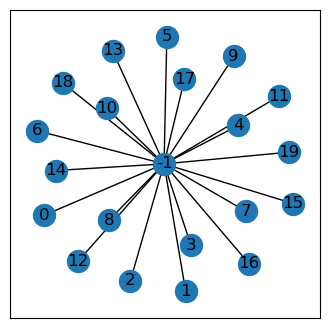

In [11]:
fig = plt.figure(figsize=(4, 4))
pos = nx.spring_layout(topo, seed = 1)
nx.draw_networkx(topo, pos = pos, node_size = 250, with_labels = True)

This graph can be considered as our initial approximation of the solution to the problem of connecting the given sources and sinks.

Final result for al=0.01, after 122 iterations and 1.6 seconds.


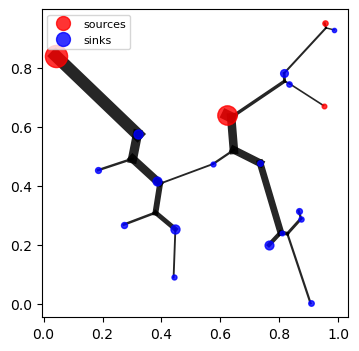

Final result for al=0.25, after 150 iterations and 1.26 seconds.


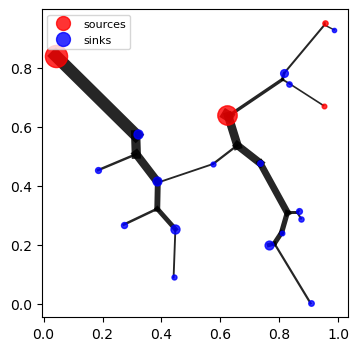

Final result for al=0.5, after 211 iterations and 2.25 seconds.


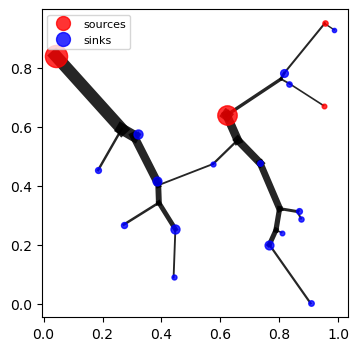

Final result for al=0.75, after 206 iterations and 2.82 seconds.


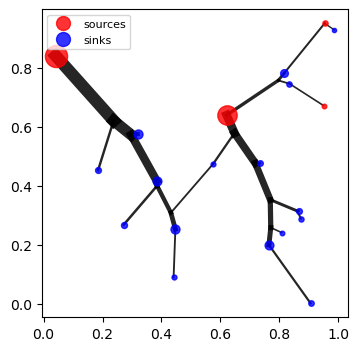

Final result for al=0.99, after 235 iterations and 19.7 seconds.


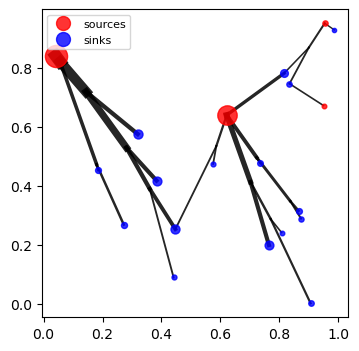

In [12]:
alphas = [0.01, 0.25, 0.50, 0.75, 0.99]

for i, al in enumerate(alphas):
    # We update the value of alpha
    bot_problem_dict["al"] = al
    
    # We create a copy of the graph
    topo_copy = topo.copy()
    # We run the geometry optimization step
    cost, coords_iter = igs.iterative_geometry_solver(topo_copy,
                                                      supply_arr, 
                                                      demand_arr, 
                                                      coords_sources, 
                                                      coords_sinks, 
                                                      al,
                                                      relative_improvement_threshold=1e-6,
                                                      min_iterations=-1,
                                                      max_iterations=1000,
                                                      plot=False,
                                                      title="",
                                                      fov=None,
                                                      save=False,
                                                      #save_name=f"img_{i+1}",
                                                      figsize=(4, 4))

    T = 0
    keep_going = True
    iteration = 0
    sample_edge_list = list(topo.edges())
    
    # We run the topology optimization
    time0 = time.time()
    while keep_going and iteration < 60000:
        iteration += 1
        topo_copy, sample_edge_list, cost, coords_iter, accepted = gto.monte_carlo_step(topo_copy, 
                                                                                   sample_edge_list, 
                                                                                   cost,
                                                                                   coords_iter, 
                                                                                   bot_problem_dict,
                                                                                   temperature=T)
        # check if converged:
        if len(sample_edge_list) == 0:
            # this means that we have stuck with one topology for an entire run through.
            keep_going = False

    print(f"Final result for al={al}, after {iteration} iterations and {np.round(time.time() - time0, 2)} seconds.")
    utils.visualise_BOT_solution(topo_copy,
                       coords_iter,
                       supply_arr,
                       demand_arr,
                       title="", fov=None, save=False, save_name="img",
                       figsize = (4,4),
                                fs = 8)
    plt.show()

As evident from the plots, the parameter $\alpha$ has a significant impact on the resulting topology of the solution. The value of $\alpha$ determines the characteristics of the network, varying from branching structures when alpha is close to 0, to more straight lines and direct connections when $\alpha$ approaches 1. By adjusting the value of $\alpha$, we can observe the transformation of the network's topology, allowing us to explore a wide range of potential solutions for the problem at hand.

Congratulations!  We have successfully constructed solutions to BOT problems with different subadditivity rates.